# **Age, Gender and Race Prediction**

### **Details**


**ETHNICITIES = [ 0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Hispanic" ]**

**GENDERS = [ 0: "Male", 1: "Female" ]**


In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as imgen
from keras.models import load_model, Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error

## Reading and fixing Dataset

In [2]:
#read
data = pd.read_csv("G:\ML-DL-NLP\GITHUB\Age, Gender and Ethnicity Prediction\Dataset/age_gender.csv")
data.head()

age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...

In [3]:
#shape
data.shape

(23705, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [5]:
# Getting Image data

def toPixels(pixels):
    arr = np.array(pixels.split(),"float64")
    arr = arr.reshape(48,48)
    
    return arr

In [6]:
%%time
data["pixels"] = data["pixels"].apply(toPixels)

Wall time: 25.6 s


In [7]:
pixels = np.reshape(data["pixels"].to_list(), (data.shape[0],48,48,1))

In [8]:
pixels.shape

(23705, 48, 48, 1)

# **Age Prediction Model**

### Generating Datsets for Age Prediction

In [9]:
x_train_age,x_test_age, y_train_age,y_test_age = train_test_split(pixels,np.array(data["age"]),random_state = 42, test_size = 0.2)
x_train_age,x_val_age, y_train_age,y_val_age = train_test_split(x_train_age,y_train_age,random_state = 21, test_size = 0.15)

In [10]:
print(x_train_age.shape,y_train_age.shape, x_test_age.shape,x_val_age.shape)

(16119, 48, 48, 1) (16119,) (4741, 48, 48, 1) (2845, 48, 48, 1)


**Image data Generator.**

In [11]:
traingen = imgen(rescale=1./255,
                zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip= True
                )
valgen = imgen(rescale=1./255,
                zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip= True
                )

testgen = imgen(rescale=1./255)

In [12]:
age_train_ds = traingen.flow(x_train_age,y_train_age,
                        batch_size = 32
                       )

age_val_ds = valgen.flow(x_val_age,y_val_age,
                        batch_size = 32
                       )

age_test_ds = testgen.flow(x_test_age,y_test_age,
                     batch_size = 32,
                    shuffle=False
                     )

**Visualizing one batch.**

In [13]:
def showImagesAge(img,label):
    plt.figure(figsize=[22,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title("Age is {}".format(label[i]))
        plt.axis('off')
    plt.show()

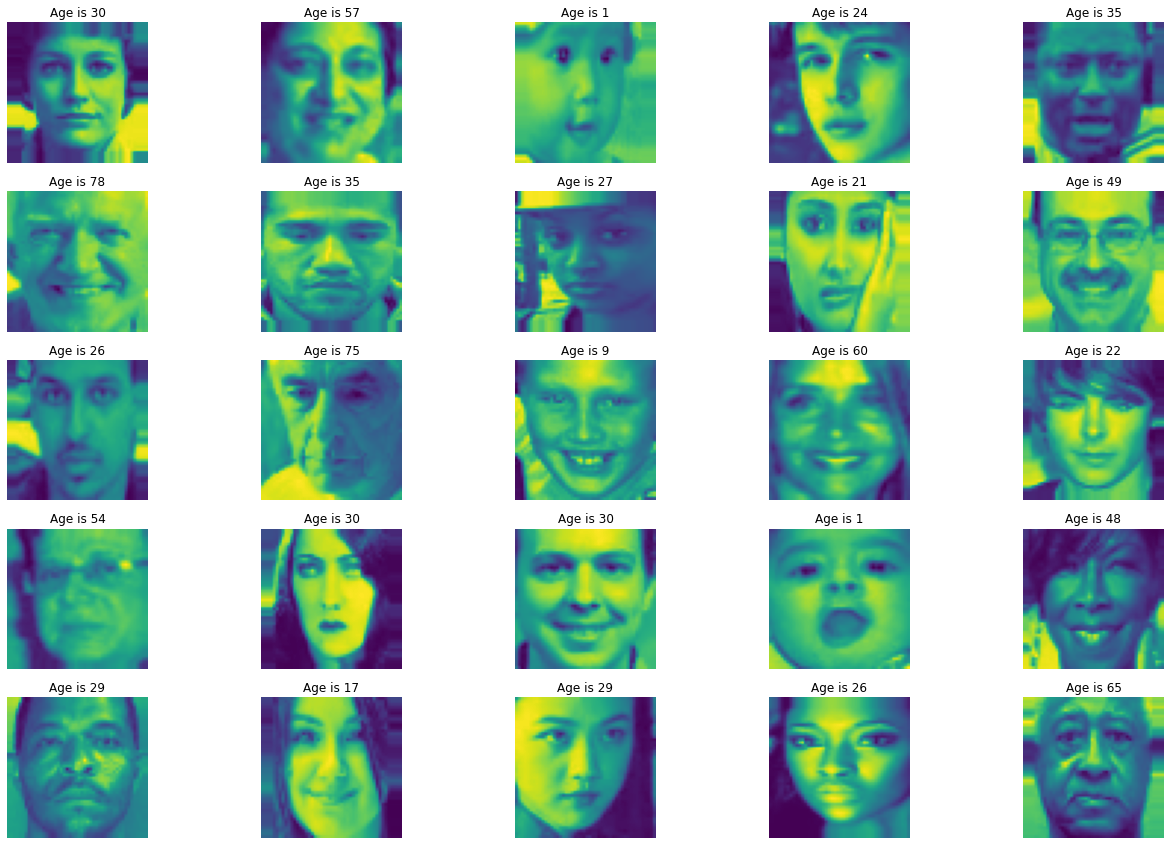

In [14]:
X,Y = next(age_train_ds)

showImagesAge(X,Y)

### Model

In [15]:
image_input = keras.Input(shape=(48,48,1))

l1 = Conv2D(32,(3,3), activation="relu")(image_input)
l2 = Conv2D(32,(3,3), activation="relu")(l1)
l3 = MaxPooling2D(pool_size=(2, 2))(l2)

l4 = Dropout(0.30)(l3)

l5 = Conv2D(64,(3,3), activation="relu")(l4)
l6 = Conv2D(128,(3,3), activation="relu")(l5)

#l7 = BatchNormalization()(l6)

l8 = Flatten()(l6)
l9 = Dense(256, activation= "relu")(l8)
image_output = Dense(1)(l9)
model_age = keras.Model(image_input, image_output)

In [16]:
model_age.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     
                                                             

In [17]:
# Compiling the model
model_age.compile(optimizer='adam', loss = 'mse', metrics=[keras.metrics.mean_absolute_error])

**Defining callbacks.**

In [18]:
my_calls = [keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',patience=3),
            keras.callbacks.ModelCheckpoint("Model_age.h5",verbose=1,save_best_only=True)]

**Training the model for age.**

In [19]:
hist_age = model_age.fit(age_train_ds,epochs=35,validation_data=age_val_ds,callbacks=my_calls)

Epoch 1/35
504/504 [==============================] - ETA: 0s - loss: 370.5990 - mean_absolute_error: 14.7330
Epoch 00001: val_loss improved from inf to 235.44919, saving model to Model_age.h5
504/504 [==============================] - 105s 207ms/step - loss: 370.5990 - mean_absolute_error: 14.7330 - val_loss: 235.4492 - val_mean_absolute_error: 11.3183
Epoch 2/35
504/504 [==============================] - ETA: 0s - loss: 226.4707 - mean_absolute_error: 11.3922
Epoch 00002: val_loss improved from 235.44919 to 207.58878, saving model to Model_age.h5
504/504 [==============================] - 102s 202ms/step - loss: 226.4707 - mean_absolute_error: 11.3922 - val_loss: 207.5888 - val_mean_absolute_error: 10.3625
Epoch 3/35
504/504 [==============================] - ETA: 0s - loss: 188.2778 - mean_absolute_error: 10.2431
Epoch 00003: val_loss improved from 207.58878 to 165.73511, saving model to Model_age.h5
504/504 [==============================] - 109s 217ms/step - loss: 188.2778 - mean_

**Test for age prediction**

In [20]:
model_age.evaluate(age_test_ds,verbose=1)

149/149 [==============================] - 8s 53ms/step - loss: 79.1390 - mean_absolute_error: 6.6792


[79.13896179199219, 6.67922830581665]

**Loss and MAE**

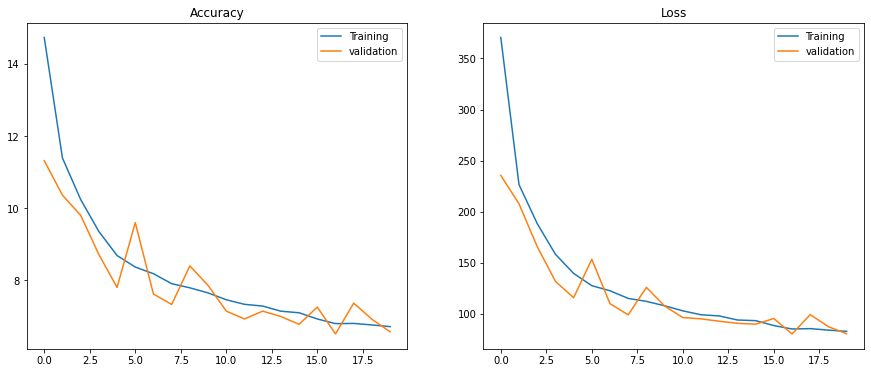

In [21]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_age.epoch,hist_age.history['mean_absolute_error'],label = 'Training')
plt.plot(hist_age.epoch,hist_age.history['val_mean_absolute_error'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_age.epoch,hist_age.history['loss'],label = 'Training')
plt.plot(hist_age.epoch,hist_age.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Verifying the Predictions**

In [22]:
pred_Age = model_age.predict(age_test_ds, verbose=1)

149/149 [==============================] - 8s 49ms/step


**Plotting predicetd v/s actual ages**

In [23]:
pred_age = []
for i in pred_Age:
    pred_age.append(np.round(i[0]))

In [24]:
def plotAgePA(image,pred,actual):
    plt.figure(figsize=[22,15])
    for i in range(500,525):
        plt.subplot(5,5,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test_age[i])
        plt.xlabel("Actual Age is {}".format(actual[i]))
        plt.ylabel("Prediced is {}".format(pred[i]))
    plt.show()

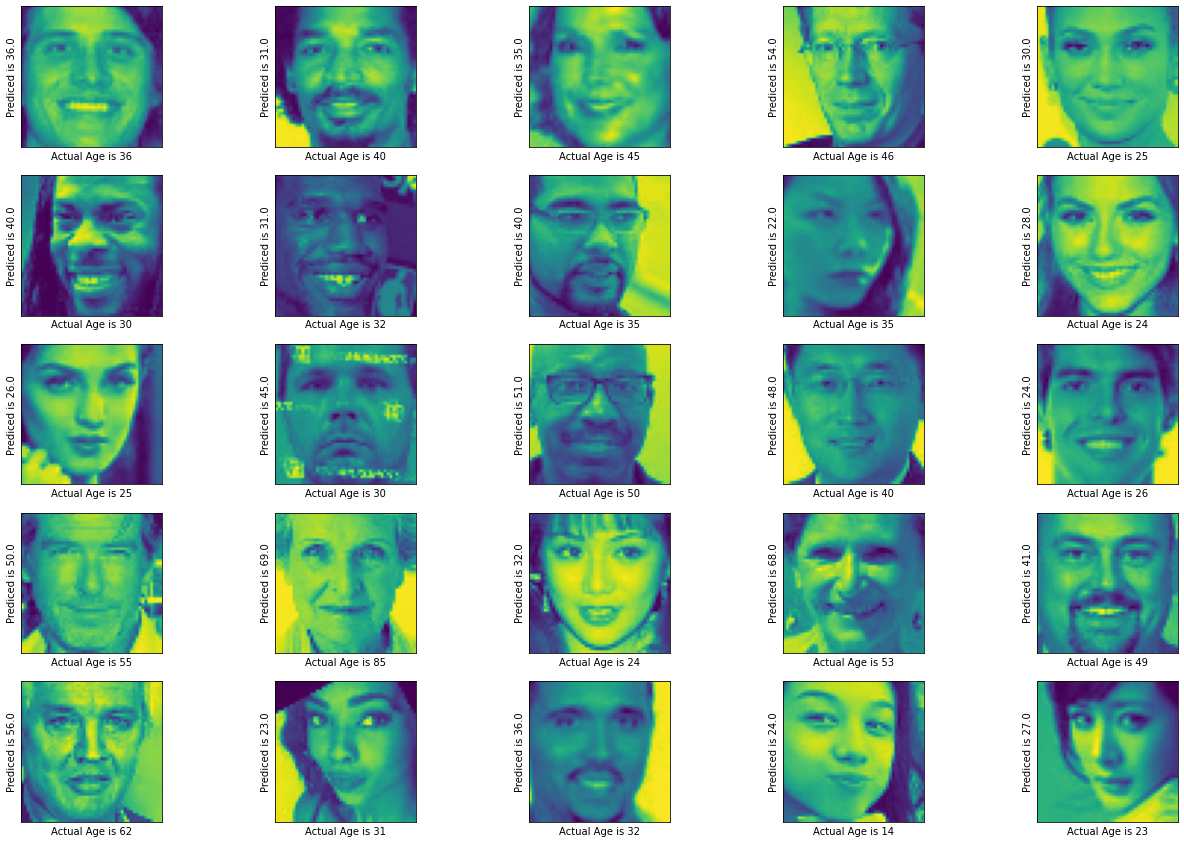

In [25]:
plotAgePA(x_test_age,pred_age,y_test_age)

# **Gender Prediction Model**

### Dataset for Gender Prediction

In [26]:
x_train_gen,x_test_gen, y_train_gen,y_test_gen = train_test_split(pixels,np.array(data["gender"]),random_state = 42, test_size = 0.2)
x_train_gen,x_val_gen, y_train_gen,y_val_gen = train_test_split(x_train_gen,y_train_gen,random_state = 21, test_size = 0.15)

In [27]:
print(x_train_gen.shape,y_train_gen.shape,x_val_gen.shape,y_val_gen.shape)

(16119, 48, 48, 1) (16119,) (2845, 48, 48, 1) (2845,)


**Data Generator**

In [28]:
gender = ["Male","Female"]

In [29]:
gen_train_ds = traingen.flow(x_train_gen,y_train_gen,
                        batch_size = 32
                       )

gen_val_ds = valgen.flow(x_val_gen,y_val_gen,
                        batch_size = 32
                       )

gen_test_ds = testgen.flow(x_test_gen,y_test_gen,
                     batch_size = 32,
                    shuffle=False
                     )

In [30]:
#one batch
def showImagesGender(img,label):
    plt.figure(figsize=[22,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title("Gender is {}".format(gender[label[i]]))
        plt.axis('off')
    plt.show()

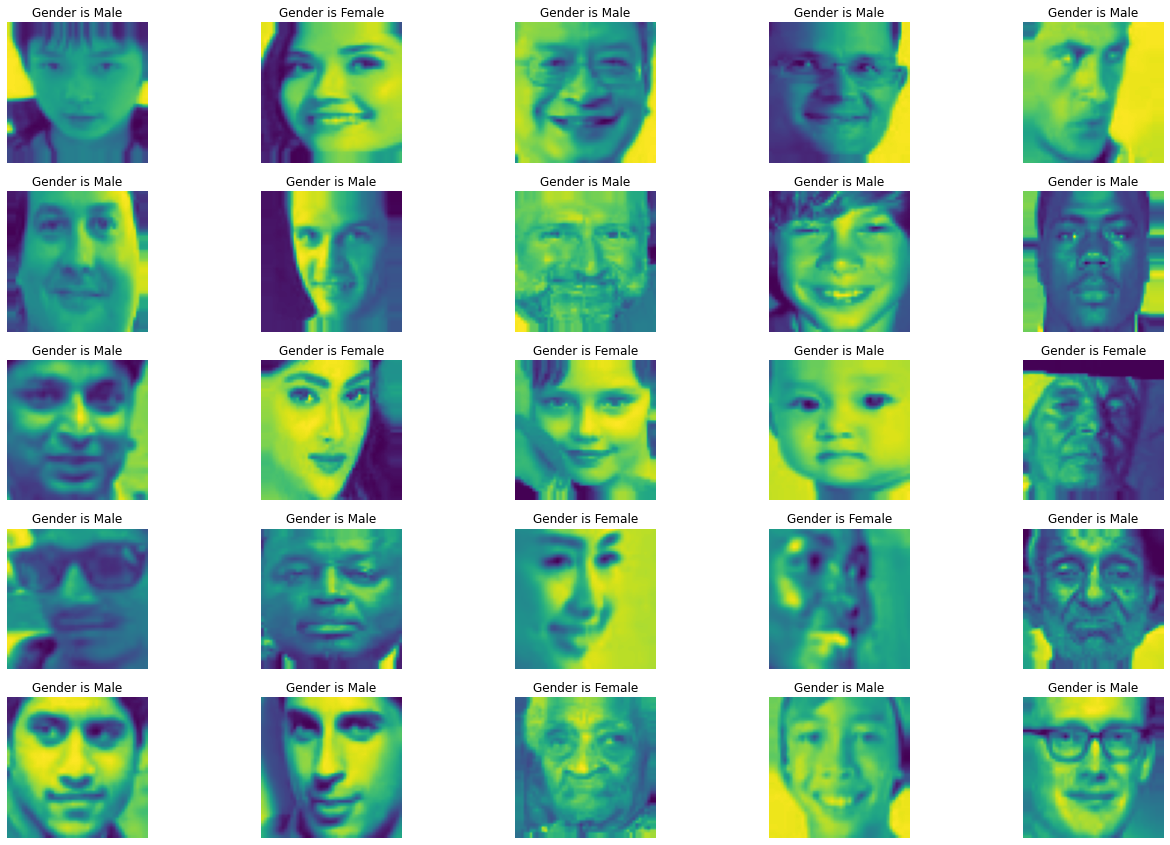

In [31]:
A,b = next(gen_train_ds)
showImagesGender(A,b)

## Model

In [32]:
model_gender = Sequential([
    Conv2D(32,(3,3), activation = "relu", input_shape = (48,48,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Dropout(0.3),
    
    Conv2D(64,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    #Conv2D(128,(3,3), activation = "relu"),
    #MaxPooling2D(2,2),
    
    Flatten(),
    
    #Dense(256,activation = 'relu'),
    #Dropout(0.5),
    
    Dense(64,activation = 'relu'),
    Dropout(0.5),
    
    
    Dense(1,activation='sigmoid')
])
model_gender.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          1

**compile the model**

In [33]:
model_gender.compile(optimizer='adam',loss = "binary_crossentropy",metrics=['accuracy'])

**Callbacks**

In [34]:
my_calls_1 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
            keras.callbacks.ModelCheckpoint("Model_Gender.h5",verbose=1,save_best_only=True)]

**Train**

In [35]:
hist_gender = model_gender.fit(gen_train_ds,epochs = 23, validation_data = gen_val_ds, callbacks = my_calls_1)

Epoch 1/23
503/504 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.6923
Epoch 00001: val_loss improved from inf to 0.47654, saving model to Model_Gender.h5
504/504 [==============================] - 28s 53ms/step - loss: 0.5840 - accuracy: 0.6923 - val_loss: 0.4765 - val_accuracy: 0.7937
Epoch 2/23
504/504 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.7799
Epoch 00002: val_loss improved from 0.47654 to 0.38895, saving model to Model_Gender.h5
504/504 [==============================] - 27s 53ms/step - loss: 0.4715 - accuracy: 0.7799 - val_loss: 0.3890 - val_accuracy: 0.8172
Epoch 3/23
503/504 [============================>.] - ETA: 0s - loss: 0.4265 - accuracy: 0.8030
Epoch 00003: val_loss improved from 0.38895 to 0.37527, saving model to Model_Gender.h5
504/504 [==============================] - 27s 53ms/step - loss: 0.4265 - accuracy: 0.8031 - val_loss: 0.3753 - val_accuracy: 0.8264
Epoch 4/23
503/504 [============================>.] -

**Test**

In [36]:
model_gender.evaluate(gen_test_ds)

149/149 [==============================] - 2s 11ms/step - loss: 0.2626 - accuracy: 0.8874


[0.26256605982780457, 0.8873655200004578]

**Loss and Accuracy**

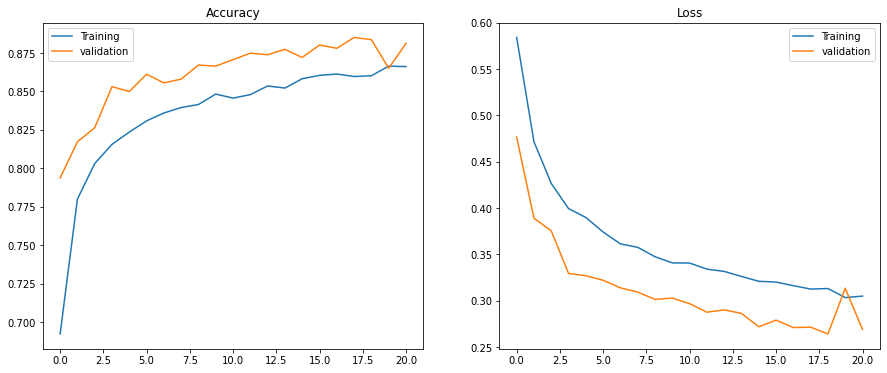

In [37]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_gender.epoch,hist_gender.history['accuracy'],label = 'Training')
plt.plot(hist_gender.epoch,hist_gender.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_gender.epoch,hist_gender.history['loss'],label = 'Training')
plt.plot(hist_gender.epoch,hist_gender.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Predictions**

In [38]:
pred_gender = model_gender.predict(gen_test_ds)

In [39]:
pred_gen = []
for i in pred_gender:
    pred_gen.append(int(np.round(i[0])))

In [40]:
pred_gen[:5]

[1, 0, 1, 0, 0]

In [41]:
print(classification_report(pred_gen,y_test_gen))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2426
           1       0.89      0.88      0.88      2315

    accuracy                           0.89      4741
   macro avg       0.89      0.89      0.89      4741
weighted avg       0.89      0.89      0.89      4741



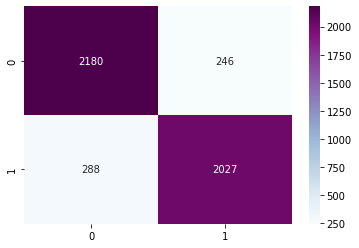

In [42]:
sns.heatmap(confusion_matrix(pred_gen,y_test_gen),annot = True, fmt = 'd', cmap = "BuPu");

In [43]:
def testGender(image,pred,actual):
    plt.figure(figsize=[22,15])
    for i in range(500,525):
        plt.subplot(5,5,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i])
        plt.xlabel("Actual Gender is {}".format(gender[actual[i]]))
        plt.ylabel("Prediced is {}".format(gender[pred[i]]))
    plt.show()

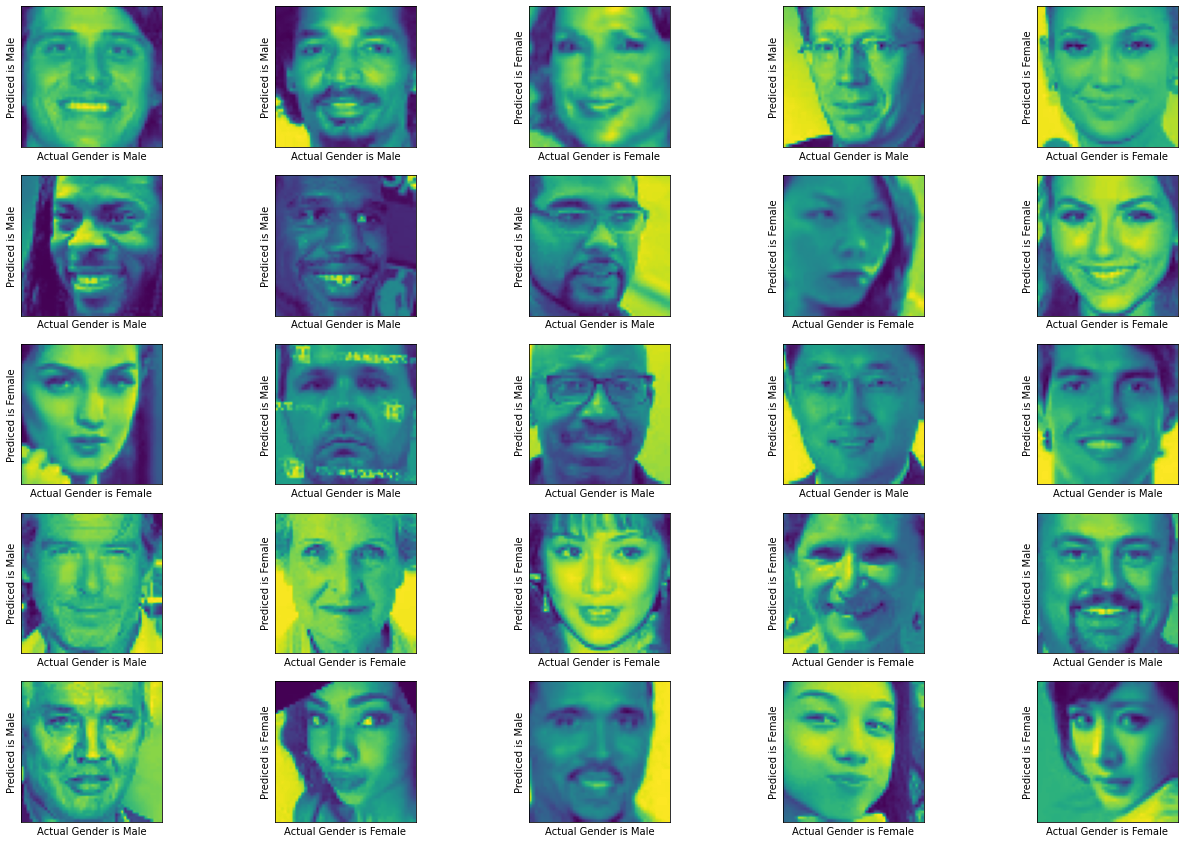

In [44]:
testGender(x_test_gen,pred_gen, y_test_gen)

# **Ethnicity Prediction**

## Data for ethnicity prediction

In [45]:
x_train_et,x_test_et, y_train_et,y_test_et = train_test_split(pixels,np.array(data["ethnicity"]),random_state = 42, test_size = 0.2)
x_train_et,x_val_et, y_train_et,y_val_et = train_test_split(x_train_et,y_train_et,random_state = 21, test_size = 0.15)

In [46]:
print(x_train_et.shape,y_train_et.shape)

(16119, 48, 48, 1) (16119,)


In [47]:
et_train_ds = traingen.flow(x_train_et,y_train_et,
                        batch_size = 32
                       )

et_val_ds = valgen.flow(x_val_et,y_val_et,
                        batch_size = 32
                       )

et_test_ds = testgen.flow(x_test_et,y_test_et,
                     batch_size = 32,
                    shuffle=False
                     )

In [48]:
#one batch
def showImagesEthnicity(img,label):
    plt.figure(figsize=[22,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title("Race is {}".format(label[i]))
        plt.axis('off')
    plt.show()

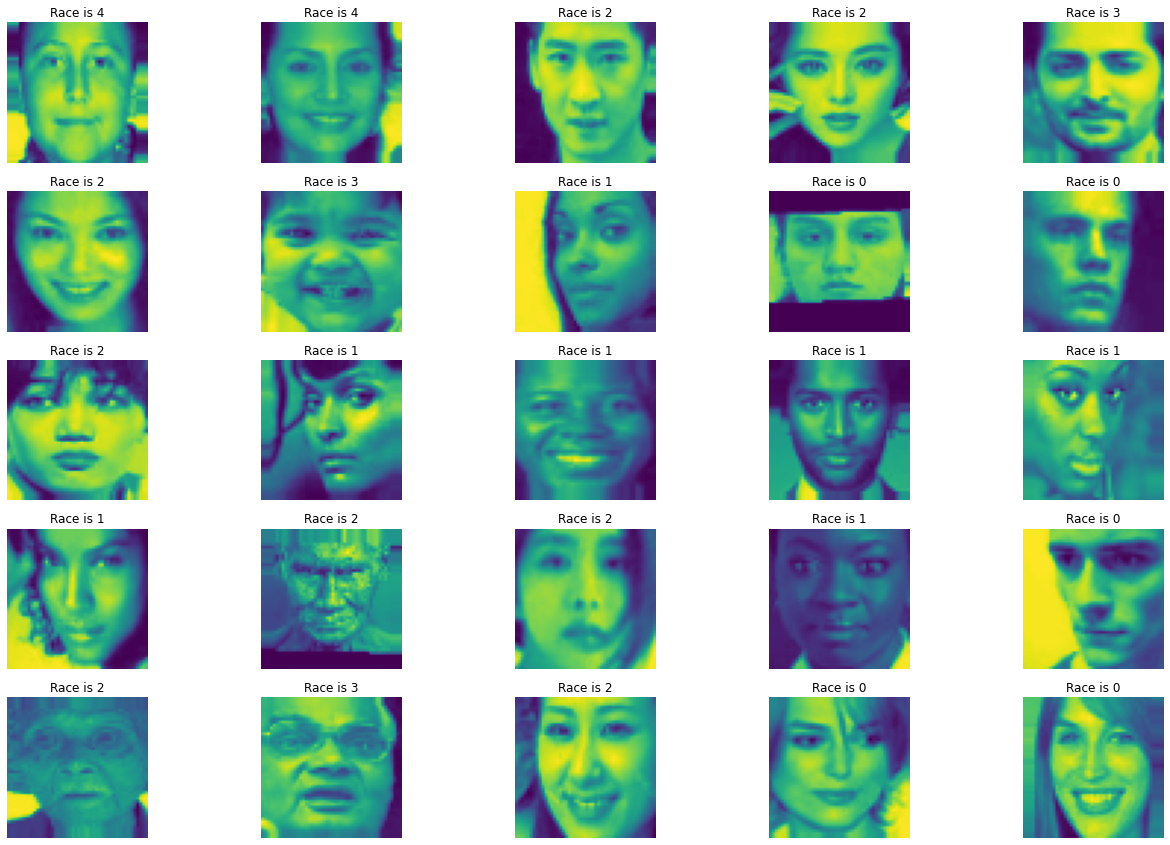

In [49]:
c,d = next(et_train_ds)
showImagesEthnicity(c,d)

## Model

In [50]:
model_et = Sequential([
    Conv2D(32,(3,3), activation = "relu", input_shape = (48,48,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Dropout(0.3),
    
    Conv2D(64,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Flatten(),
    
    Dense(256,activation = 'relu'),
    Dropout(0.5),
    
    #Dense(64,activation = 'relu'),
    #Dropout(0.5),
    
    
    Dense(5,activation='softmax')
])
model_et.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 64)         

**Compile the model**

In [51]:
model_et.compile(optimizer='adam',loss = "sparse_categorical_crossentropy",metrics=['accuracy'])

**Callbacks**

In [52]:
my_calls_2 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
            keras.callbacks.ModelCheckpoint("Model_Ethnicity.h5",verbose=1,save_best_only=True)]

**Train**

In [53]:
hist_et = model_et.fit(et_train_ds,epochs=22,validation_data=et_val_ds,callbacks=my_calls_2)

Epoch 1/22
503/504 [============================>.] - ETA: 0s - loss: 1.4077 - accuracy: 0.4473
Epoch 00001: val_loss improved from inf to 1.32489, saving model to Model_Ethnicity.h5
504/504 [==============================] - 29s 54ms/step - loss: 1.4077 - accuracy: 0.4474 - val_loss: 1.3249 - val_accuracy: 0.4780
Epoch 2/22
503/504 [============================>.] - ETA: 0s - loss: 1.2109 - accuracy: 0.5295
Epoch 00002: val_loss improved from 1.32489 to 0.98803, saving model to Model_Ethnicity.h5
504/504 [==============================] - 27s 53ms/step - loss: 1.2105 - accuracy: 0.5296 - val_loss: 0.9880 - val_accuracy: 0.6408
Epoch 3/22
503/504 [============================>.] - ETA: 0s - loss: 1.0251 - accuracy: 0.6217
Epoch 00003: val_loss improved from 0.98803 to 0.90342, saving model to Model_Ethnicity.h5
504/504 [==============================] - 27s 53ms/step - loss: 1.0251 - accuracy: 0.6217 - val_loss: 0.9034 - val_accuracy: 0.6615
Epoch 4/22
503/504 [========================

**Test**

In [54]:
model_et.evaluate(et_test_ds)

149/149 [==============================] - 2s 12ms/step - loss: 0.7297 - accuracy: 0.7277


[0.7296868562698364, 0.727694571018219]

**Loss and Accuracy**

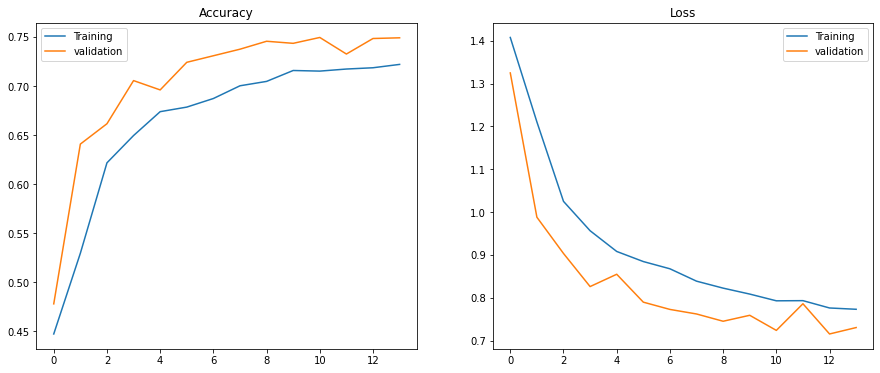

In [55]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_et.epoch,hist_et.history['accuracy'],label = 'Training')
plt.plot(hist_et.epoch,hist_et.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_et.epoch,hist_et.history['loss'],label = 'Training')
plt.plot(hist_et.epoch,hist_et.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Predictions**

In [56]:
pred_et = model_et.predict(et_test_ds)

In [57]:
pred_et = [np.argmax(i) for i in pred_et]
pred_et[:5]

[3, 1, 2, 3, 0]

In [58]:
pd.DataFrame(pred_et).value_counts()

0    1930
1    1052
2     878
3     870
4      11
dtype: int64

In [59]:
pd.DataFrame(y_test_et).value_counts()

0    2047
1     904
3     804
2     657
4     329
dtype: int64

In [60]:
print(classification_report(pred_et,y_test_et))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1930
           1       0.86      0.74      0.79      1052
           2       0.85      0.64      0.73       878
           3       0.69      0.64      0.66       870
           4       0.01      0.36      0.02        11

    accuracy                           0.73      4741
   macro avg       0.63      0.64      0.60      4741
weighted avg       0.78      0.73      0.75      4741



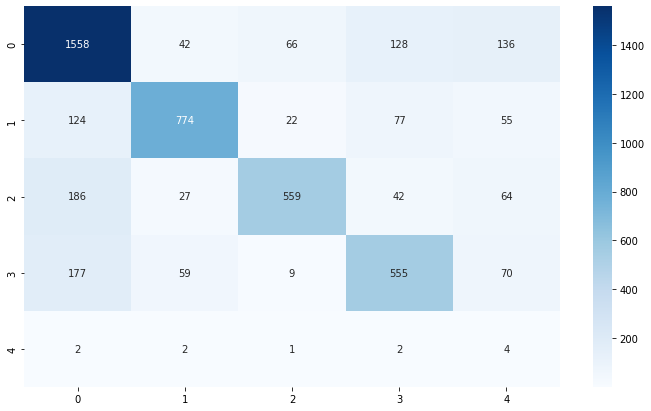

In [61]:
plt.figure(figsize=[12,7])
sns.heatmap(confusion_matrix(pred_et,y_test_et),annot=True,fmt='d',cmap="Blues");